# Notebook for Face Detection Using Histogram of Oriented Gradients and Face Recognition Using FaceNet

### Importing Libraries


In [68]:
import os
import sys  
sys.path.insert(0, r'C:\Users\aishw\PycharmProjects\FaceRecognition')
import pickle
import numpy as np
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import load_model
import seaborn as sns
import dlib
from architecture import *
import cv2
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn import metrics
import random
import pandas as pd

### File Paths and Initializing Detector and Encoder

In [2]:
face_data = 'train_img'
required_shape = (160, 160)
face_encoder = InceptionResNetV2()
encoder_weights_path = 'facenet_keras_weights.h5'
print('Initializing Face Detector Object...')
face_detector = dlib.get_frontal_face_detector()
print('Face Detector Object Initialized.')
print('Loading Weights into FaceNet...')
face_encoder.load_weights(encoder_weights_path)
print('Weights Loaded into FaceNet.')

Initializing Face Detector Object...
Face Detector Object Initialized.
Loading Weights into FaceNet...
Weights Loaded into FaceNet.


In [3]:
encoding_dict = dict()
l2_normalizer = Normalizer('l2')

#### Normalize Function

In [4]:
def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

### Check and Save Extracted Faces to a Directory

#### Create Folders

In [114]:
extracted_face = 'face_extracted_hog'
if not os.path.exists(extracted_face):
    os.mkdir(extracted_face)
for faces_names in os.listdir(face_data):
    if not os.path.exists(os.path.join(extracted_face, faces_names)):
        os.mkdir(os.path.join(extracted_face, faces_names))

#### Save Extracted Faces

In [6]:
for face_names in os.listdir(face_data):
    person_dir = os.path.join(face_data, face_names)
    i = 0
    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir, image_name)
        img_BGR = cv2.imread(image_path)
        img_GRAY = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
        rects = face_detector(img_GRAY, 0)
        if len(rects) > 0:
            rect = rects[0]
            x1, y1, width, height = rect.left(), rect.top(), rect.width(), rect.height()
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            face = img_BGR[y1: y2, x1: x2]
            cv2.imwrite(os.path.join(os.path.join(extracted_face, face_names), str(i) + '.jpg'), face)
            i += 1

## Training of FaceNet

In [7]:
def train_FaceNet_using_HOG():
    for face_names in os.listdir(face_data):
        person_dir = os.path.join(face_data, face_names)
        encodes = []
        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)
            img_BGR = cv2.imread(image_path)
            img_GRAY = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
            rects = face_detector(img_GRAY, 0)
            print(len(rects))
            if len(rects) == 0:
                continue
            rect = rects[0]
            x1, y1, width, height = rect.left(), rect.top(), rect.width(), rect.height()
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            face = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)[y1: y2, x1: x2]
            face = normalize(face)
            face = cv2.resize(face, required_shape)
            face_d = np.expand_dims(face, axis=0)
            encode = face_encoder.predict(face_d)[0]
            encodes.append(encode)
        if encodes:
            encode = np.sum(encodes, axis = 0)
            encode = l2_normalizer.transform(np.expand_dims(encode, axis = 0))[0]
            encoding_dict[face_names] = encode
            print(str(face_names), ' appended!')
    path = 'encoding/encodings_HOG.pkl'
    with open(path, 'wb') as file:
        pickle.dump(encoding_dict, file)

In [8]:
train_FaceNet_using_HOG()

1
1
1
0
1
Aishwarya Patange  appended!
0
0
1
1
1
1
1
1
Ajita Patange  appended!
1
1
1
1
0
Akshay Ghaisas  appended!
0
1
0
0
0
0
1
1
0
Amul Patange  appended!
1
1
1
1
1
Aneesh Pol  appended!
1
1
1
1
1
Anjali Patil  appended!
1
1
1
1
1
Ankita Mandal  appended!
1
1
1
1
1
Anoushka Thakker  appended!
1
1
1
0
1
Apoorva Sudheesh  appended!
1
1
1
1
1
Arya Dalvi  appended!
1
1
1
1
1
Arya Kasulla  appended!
1
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
Aryan Patange  appended!
1
1
1
1
1
0
Atharva Sawantdesai  appended!
1
1
1
1
1
Atique Kudchi  appended!
1
1
1
0
1
Avikshit Dabholkar  appended!
1
1
1
1
1
Balasaheb Patil  appended!
1
1
0
1
1
Dhananjay Teli  appended!
1
1
1
1
1
Disha Mhatre  appended!
1
1
1
1
0
Harshal Marathe  appended!
1
1
1
1
0
Isha Naik  appended!
1
1
1
0
1
Itisha Dalvi  appended!
1
1
1
1
1
Kunal Khaladkar  appended!
1
1
1
1
1
Lavanya Soparkar  appended!
1
0
1
0
1
1
1
Mihir Sabnis  appended!
1
1
1
1
1
Nrupaja Vartak  appended!
1
1
1
1
1
Riya Kasulla  appended!
1
1
1
1
1
1
1
1
1
1
Rucha Naik  

## Identifying People In A Single Frame

### Utility Functions

In [130]:
confidence_t = 0.99
recognition_t = 0.39

In [10]:
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

In [11]:
def get_encode(face_encoder, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
    return encode

In [12]:
def load_pickle(path):
    with open(path, 'rb') as f:
        encoding_dict = pickle.load(f)
    return encoding_dict

In [117]:
def detect(img, face_detector, face_encoder, encoding_dict):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = face_detector(img_GRAY, 0)
    name = 'unknown'
    for rect in rects:
        name = 'unknown'
        box = (rect.left(), rect.top(), rect.width(), rect.height())
        face, pt_1, pt_2 = get_face(img_RGB, box)
        encode = get_encode(face_encoder, face, required_shape)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist
        if name == 'unknown':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        else:
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            cv2.putText(img, name + ' ' + str(round(distance, 2)), (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 200), 2)
            #cv2.putText(img, name, (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    return img, name

### Main Function

In [99]:
def identify_Using_FaceNet():
    encodings_path = 'encoding/encodings_HOG.pkl'
    encoding_dict = load_pickle(encodings_path)
    frame = cv2.imread('train_img/Harshal Marathe/IMG-20210210-WA0020.jpg')
    frame, names = detect(frame, face_detector, face_encoder, encoding_dict)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print(names)
    plt.imshow(frame)
    plt.show()

Harshal Marathe


<IPython.core.display.Javascript object>


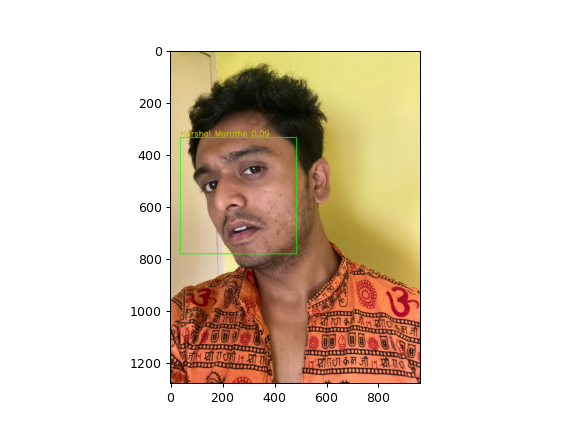

In [100]:
identify_Using_FaceNet()

## Figures of Merit and Confusion Matrix of Training Data

In [61]:
def pred_vs_actual_training_data():
    y_actual = []
    y_pred = []
    encodings_path = 'encoding/encodings_HOG.pkl'
    encoding_dict = load_pickle(encodings_path)
    for face_names in random.sample(os.listdir(face_data), len(os.listdir(face_data))):
        person_dir = os.path.join(face_data, face_names)
        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)
            frame = cv2.imread(image_path)
            _, names = detect(frame, face_detector, face_encoder, encoding_dict)
            y_actual.append(str(face_names))
            y_pred.append(names)
    return y_actual, y_pred

In [62]:
y_actual, y_pred = pred_vs_actual_training_data()

In [64]:
print(metrics.confusion_matrix(y_actual, y_pred, labels=os.listdir(face_data)))

[[4 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 5]]


In [66]:
print(metrics.classification_report(y_actual, y_pred, labels=os.listdir(face_data)))

                     precision    recall  f1-score   support

  Aishwarya Patange       1.00      0.80      0.89         5
      Ajita Patange       1.00      0.75      0.86         8
     Akshay Ghaisas       1.00      0.80      0.89         5
       Amul Patange       1.00      0.33      0.50         9
         Aneesh Pol       1.00      1.00      1.00         5
       Anjali Patil       1.00      1.00      1.00         5
      Ankita Mandal       1.00      1.00      1.00         5
   Anoushka Thakker       1.00      1.00      1.00         5
   Apoorva Sudheesh       1.00      0.80      0.89         5
         Arya Dalvi       1.00      1.00      1.00         5
       Arya Kasulla       1.00      1.00      1.00         5
      Aryan Patange       1.00      0.62      0.77        16
Atharva Sawantdesai       1.00      0.83      0.91         6
      Atique Kudchi       1.00      1.00      1.00         5
 Avikshit Dabholkar       1.00      0.80      0.89         5
    Balasaheb Patil    

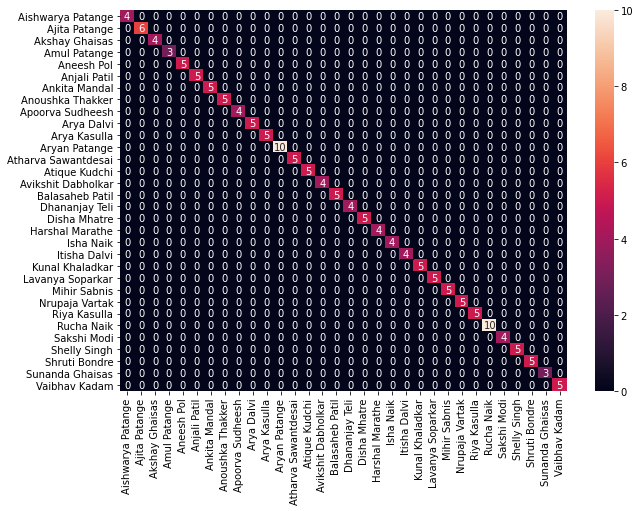

In [69]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred, labels=os.listdir(face_data)), index = os.listdir(face_data), columns = os.listdir(face_data))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [131]:
test_dir = 'test_img'
output_dir = 'output_dir'
for face_names in os.listdir(test_dir):
        person_dir = os.path.join(test_dir, face_names)
        person_output = os.path.join(output_dir, face_names)
        for image_name in os.listdir(person_dir):
            frame = cv2.imread(os.path.join(person_dir, image_name))
            frame, names = detect(frame, face_detector, face_encoder, encoding_dict)
            if (image_name[-4:] == 'jpeg'):
                image_name = image_name[0:-5] + '_hog.jpg'
            else:
                image_name = image_name[0:-4] + '_hog.jpg'
            cv2.imwrite(os.path.join(person_output, image_name), frame)